# ada-SGD algorithms
*In this lab, You will explore Adagrad, Adadelta, and Adam optimizers.

*For each task, you are provided with a code skeleton that you need to complete to implement and investigate the respective optimization algorithm.

# Task 1: Implement Adagrad
In this task, you will implement the Adagrad optimizer from scratch as a Python class, and call it to minimize the loss of classification bY any simple NN and dataset, "recommended to have small NN and simple dataset to accelerate the running"


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# Task: Implement the Adadelta optimizer from scratch
class AdagradOptimizer:
    def __init__(self, params, lr=0.9, eps=1e-6):
        self.params = list(params)
        self.lr = lr
        self.eps = eps
        self.state = []

    def step(self):
        # Implement adagrad update rule
        for i, param in enumerate(self.params):
            if len(self.state) <= i:
                self.state.append(torch.zeros_like(param))
            self.state[i] = self.state[i] + param.grad ** 2
            param.data -= param.grad * self.lr / (torch.sqrt(self.state[i]) + self.eps)


    def sgd_step(self):
        for i, param in enumerate(self.params):
            param.data -= param.grad * self.lr


In [71]:
# Define a simple neural network
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return F.sigmoid(self.fc(x))

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        return F.sigmoid(self.fc2(F.relu(self.fc1(x))))

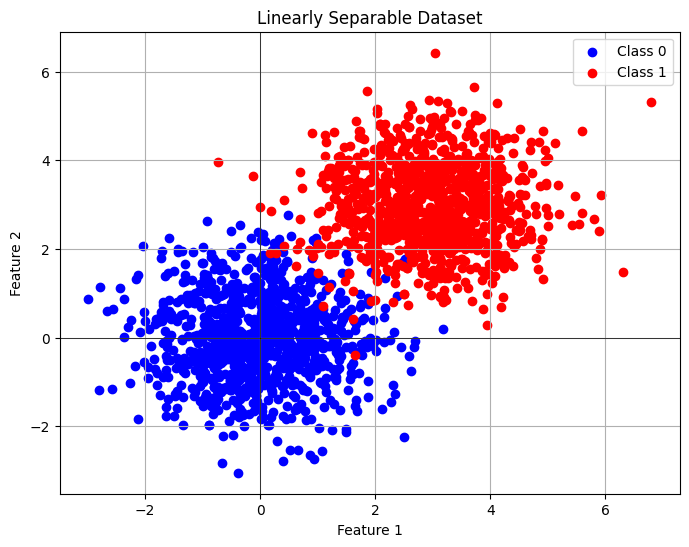

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples
n_samples = 1000

# Generating random points
np.random.seed(0)

# data
X = np.random.normal(loc=0, scale=1, size=(n_samples, 2))
X = np.concatenate([X, np.random.normal(loc=3, scale=1, size=(n_samples, 2))])

## labels
Y = np.zeros(n_samples)
Y = np.concatenate([Y, np.ones(n_samples)])

# Plotting the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], color='b', label='Class 0')
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linearly Separable Dataset')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()

In [5]:
## create dataset and dataloader
from torch.utils.data import TensorDataset, DataLoader

## split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


# Convert X_train and Y_train to tensors
X = torch.tensor(X_train, dtype=torch.float)
Y = torch.tensor(Y_train, dtype=torch.float)

X_test = torch.tensor(X_test, dtype=torch.float)
Y_test = torch.tensor(Y_test, dtype=torch.float)


# Define dataset
batch_size = 16
trainset = TensorDataset(X, Y)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test, Y_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [6]:
def train(model, dataloader, testloader, criterion, optimizer, num_epochs=100, verbose=True, full_grad=False):
    # Task: Complete the training loop
    hist_loss, acc_loss = [], []
    hist_loss_test, acc_loss_test = [], []
    for epoch in range(num_epochs):
        if full_grad:
            criterion(model(X).squeeze(), Y).backward()
            full_grad = [param.grad for param in model.parameters()]
        epoch_loss = 0
        acc_epoch = 0
        for batch_idx, (data, target) in enumerate(dataloader):

            # Clear gradients
            model.zero_grad()

            # Forward pass
            output = model(data)

            # Compute loss
            loss = criterion(output.squeeze() , target)

            # Backpropagation
            loss.backward()

            # Update model parameters
            if full_grad:
                optimizer.step(full_grad)
            else:
                optimizer.step()

            # Print training loss
            epoch_loss += loss.item()

            # calculate accuracy
            acc_epoch += ((output.squeeze() > 0.5) == target).sum().item()

        hist_loss.append(epoch_loss / len(dataloader))
        acc_loss.append(acc_epoch / len(trainset))

        if verbose:
            print('Epoch: ', epoch, 'Loss: ', epoch_loss / len(dataloader), 'Accuracy: ', acc_epoch / len(dataset))


        with torch.no_grad():
            epoch_loss = 0
            acc_epoch = 0
            for batch_idx, (data, target) in enumerate(testloader):
                # Forward pass
                output = model(data)

                # Compute loss
                loss = criterion(output.squeeze(), target)

                # Print training loss
                epoch_loss += loss.item()

                # calculate accuracy
                acc_epoch += ((output.squeeze() > 0.5) == target).sum().item()

            if verbose:
                print('Test Loss: ', epoch_loss / len(testloader), 'Test Accuracy: ', acc_epoch / len(testset))

            hist_loss_test.append(epoch_loss / len(testloader))
            acc_loss_test.append(acc_epoch / len(testset))

    return hist_loss, acc_loss, hist_loss_test, acc_loss_test

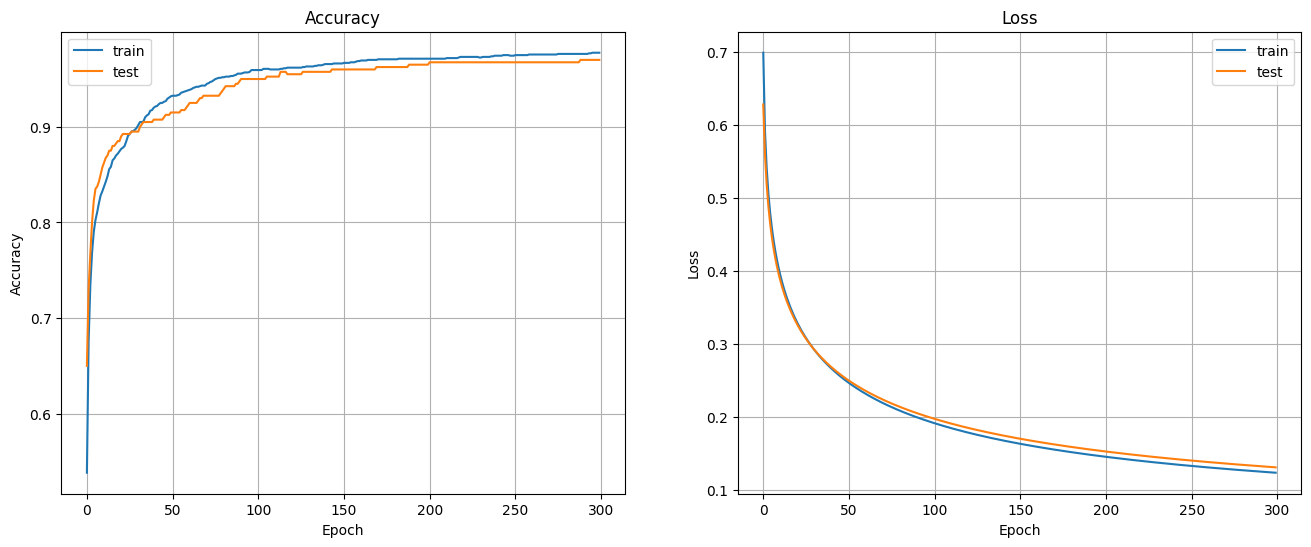

In [7]:

lr = 0.01

net = SimpleNet(2, 1)
criterion = nn.BCELoss()
# optimizer = optim.Adagrad(net.parameters(), lr=lr)  # Use Adagrad optimizer only to make sure your code is working
optimizer = AdagradOptimizer(net.parameters(), lr=lr)

hist_loss, hist_acc, hist_test_loss, hist_acc_test = train(net, trainloader, testloader, criterion, optimizer, num_epochs=300, verbose=False)

## plot 2 figures for accuracy and loss side by side
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(hist_acc, label='train')
plt.plot(hist_acc_test, label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist_loss, label='train')
plt.plot(hist_test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Task 2: Implement Adadelta

In this task instead of adagrad which uses all the past gradient to estimate the variance of the gradients, small window of past gradient are used only. However, instead of using the squared gradient, we encourage you to propose another idea to have adaptive step size propotional to the curvature (inversly), remember the main idea of adagrad and adadelta is to update the model weights differently (adaptively) along every dimension based on the curvature of the loss.

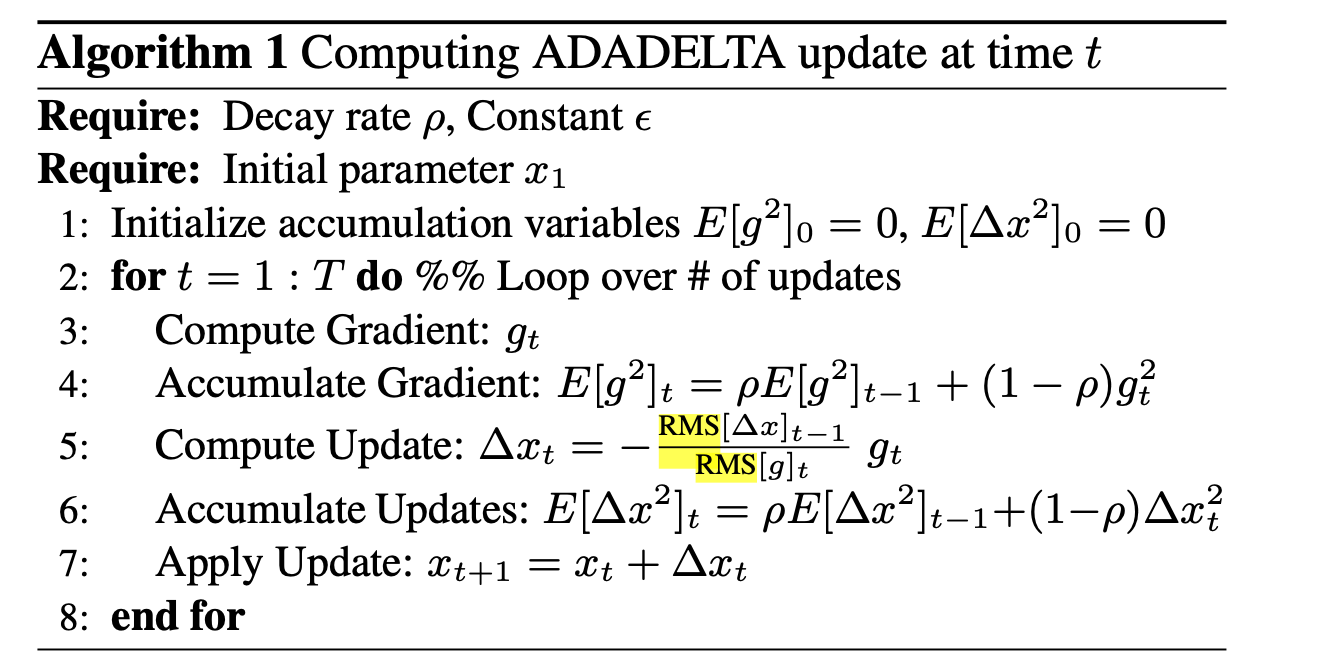

In [8]:
# Task: Implement the Adadelta optimizer from scratch with new G
class AdadeltaOptimizer:
    def __init__(self, params, rho=0.9, eps=1e-6):
        self.params = list(params)
        self.rho = rho
        self.eps = eps
        self.state_mean_grad  = []
        self.state_mean_delta = []

    def step(self):
        for i, param in enumerate(self.params):
            if len(self.state_mean_grad) <= i:
                self.state_mean_grad.append(torch.zeros_like(param))
                self.state_mean_delta.append(torch.zeros_like(param))

            self.state_mean_grad[i] = self.rho * self.state_mean_grad[i] + (1 - self.rho) * param.grad ** 2
            delta = - (torch.sqrt(self.state_mean_delta[i] + self.eps) / torch.sqrt(self.state_mean_grad[i] + self.eps)) * param.grad
            self.state_mean_delta[i] = self.rho * self.state_mean_delta[i] + (1 - self.rho) * delta ** 2
            param.data = param.data + delta

In [9]:

class AdaptiveCurvatureAdadelta:
    def __init__(self, params, rho=0.9, eps=1e-6):
        self.params = list(params)
        self.rho = rho
        self.eps = eps
        self.moving_avg_grad = [torch.zeros_like(p) for p in self.params]
        self.moving_avg_delta = [torch.zeros_like(p) for p in self.params]

    def step(self):
        for p, avg_grad, avg_delta in zip(self.params, self.moving_avg_grad, self.moving_avg_delta):
            if p.grad is None:
                continue

            # Update moving average of gradients
            avg_grad.mul_(self.rho)
            avg_grad.add_((1 - self.rho) * p.grad.data)

            # Estimate curvature
            grad_diff = p.grad.data - avg_grad
            curvature = grad_diff.norm()

            # Compute parameter update
            rms_avg_grad = (avg_grad.norm() + self.eps).sqrt()
            rms_avg_delta = (avg_delta + self.eps).sqrt()
            delta = - (rms_avg_delta / (rms_avg_grad * curvature)) * p.grad.data

            # Update parameters
            p.data.add_(delta)

            # Update moving average of deltas
            avg_delta.mul_(self.rho)
            avg_delta.add_((1 - self.rho) * delta.pow(2))


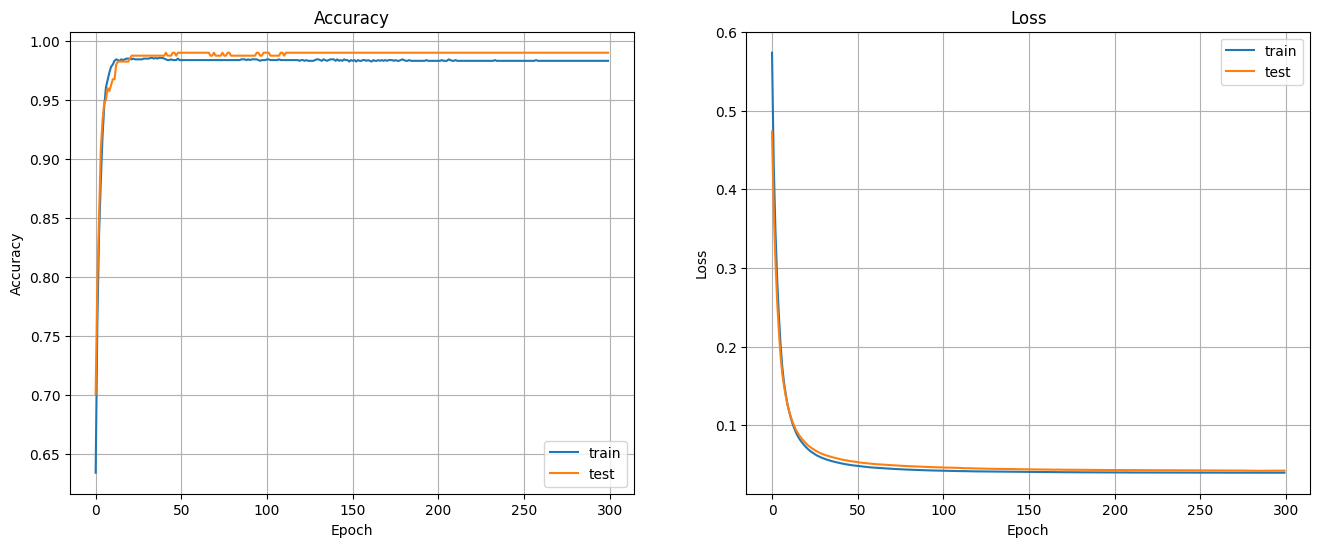

In [10]:

lr = 0.01

net = SimpleNet(2, 1)
criterion = nn.BCELoss()
optimizer = AdadeltaOptimizer(net.parameters(), rho=0.8, eps=1e-6)
# optimizer = AdaptiveCurvatureAdadelta(net.parameters(), rho=0.8, eps=1e-6)
# optimizer = optim.Adadelta(net.parameters(), lr=.001, rho=.999, eps=1e-8)


hist_loss, hist_acc, hist_test_loss, hist_acc_test = train(net, trainloader, testloader, criterion, optimizer, num_epochs=300, verbose=False)

## plot 2 figures for accuracy and loss side by side
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(hist_acc, label='train')
plt.plot(hist_acc_test, label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist_loss, label='train')
plt.plot(hist_test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Task 3: Implement Adam

Compare the ||momentum vector - full gradient || with || stochastic gradient - full gradient|| . And then change the norm to weighted Euclidean norm with weight from Adam (scaling vector)

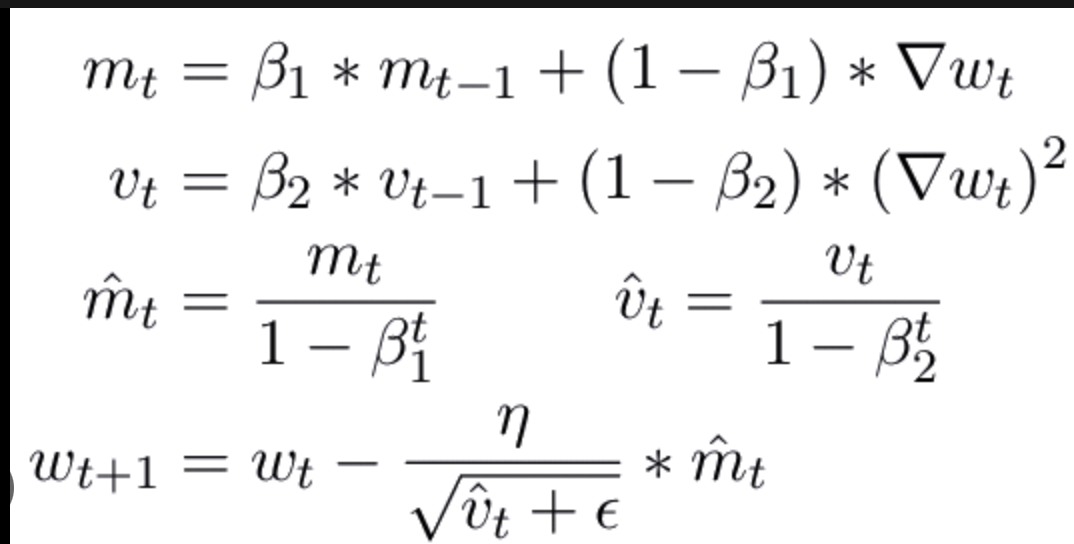

In [11]:
# Implement Adam optimizer from scratch

# Your code goes here
class Adam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.9, eps=1e-6):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.state_v = [torch.zeros_like(p) for p in self.params]
        self.state_m = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def iterate(self):
        self.t += 1

    def step(self):
        self.iterate()

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            self.state_m[i] = self.beta1 * self.state_m[i] + (1 - self.beta1) * param.grad
            self.state_v[i] = self.beta2 * self.state_v[i] + (1 - self.beta2) * param.grad ** 2

            m_hat = self.state_m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.state_v[i] / (1 - self.beta2 ** self.t)

            param.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

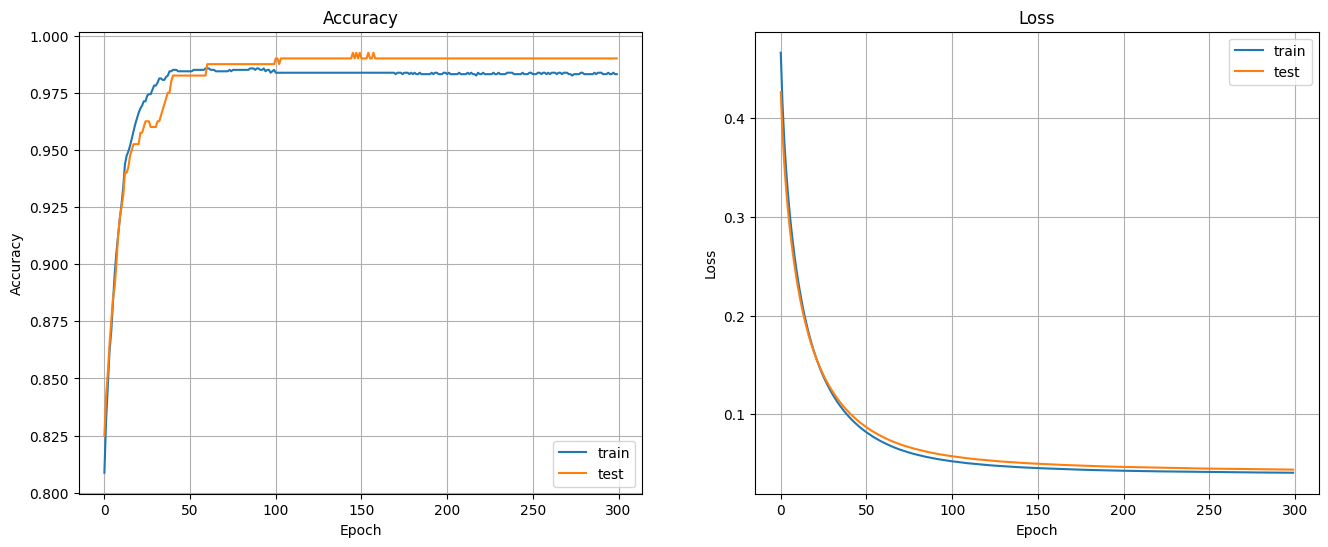

In [13]:

lr = 0.01

net = SimpleNet(2, 1)
criterion = nn.BCELoss()
optimizer = Adam(net.parameters(), lr=.001, beta1=.9, beta2=.999, eps=1e-8)

hist_loss, hist_acc, hist_test_loss, hist_acc_test = train(net, trainloader, testloader, criterion, optimizer, num_epochs=300, verbose=False)

## plot 2 figures for accuracy and loss side by side
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(hist_acc, label='train')
plt.plot(hist_acc_test, label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist_loss, label='train')
plt.plot(hist_test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

## ADAM from OPTIMIZER

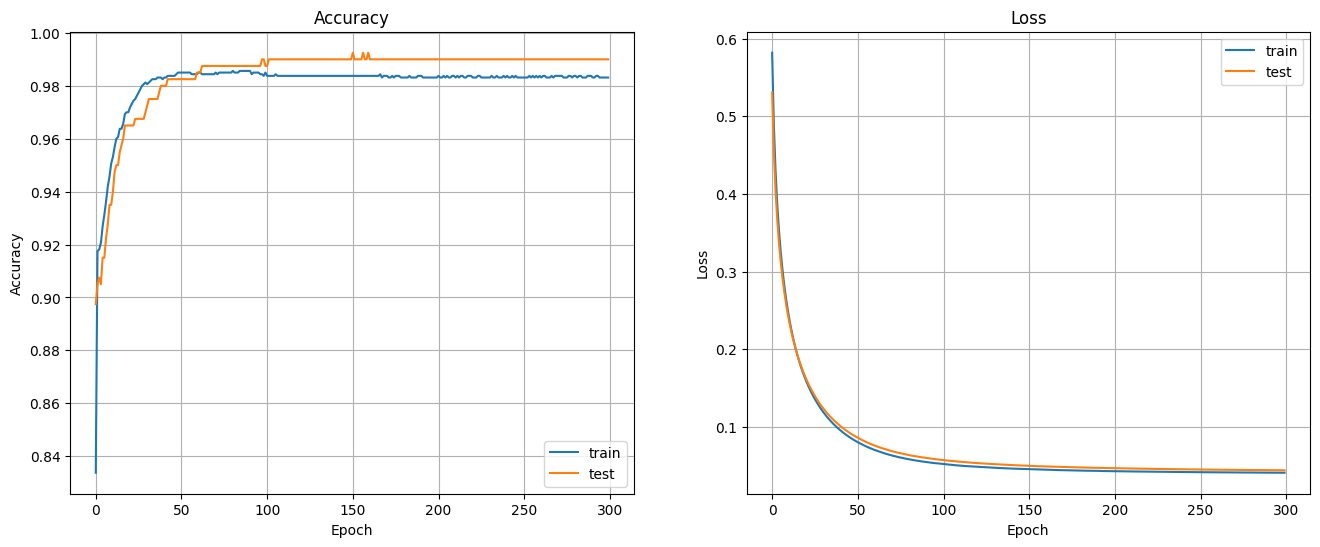

In [14]:

lr = 0.01

net = SimpleNet(2, 1)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=.001)

hist_loss, hist_acc, hist_test_loss, hist_acc_test = train(net, trainloader, testloader, criterion, optimizer, num_epochs=300, verbose=False)

## plot 2 figures for accuracy and loss side by side
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(hist_acc, label='train')
plt.plot(hist_acc_test, label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist_loss, label='train')
plt.plot(hist_test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [15]:

class CustomAdamOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.betas = betas
        self.eps = eps
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self, full_gradient):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue

            # Update first and second moment vectors
            self.m[i] = self.betas[0] * self.m[i] + (1 - self.betas[0]) * p.grad.data
            self.v[i] = self.betas[1] * self.v[i] + (1 - self.betas[1]) * p.grad.data.pow(2)

            # Compute bias-corrected first and second moments
            m_hat = self.m[i] / (1 - self.betas[0] ** self.t)
            v_hat = self.v[i] / (1 - self.betas[1] ** self.t)

            # Compute weighted norms
            weighted_norm_momentum = torch.norm(m_hat - full_gradient[i], 2) / torch.sqrt(v_hat + self.eps)
            weighted_norm_stochastic = torch.norm(p.grad.data - full_gradient[i], 2) / torch.sqrt(v_hat + self.eps)

            # Compare and adjust the update
            if torch.norm(weighted_norm_momentum - weighted_norm_stochastic) < 0:
                # Use momentum based update
                update = m_hat
            else:
                # Use stochastic gradient based update
                update = p.grad.data

            # Apply update
            p.data -= self.lr * update / (torch.sqrt(v_hat) + self.eps)

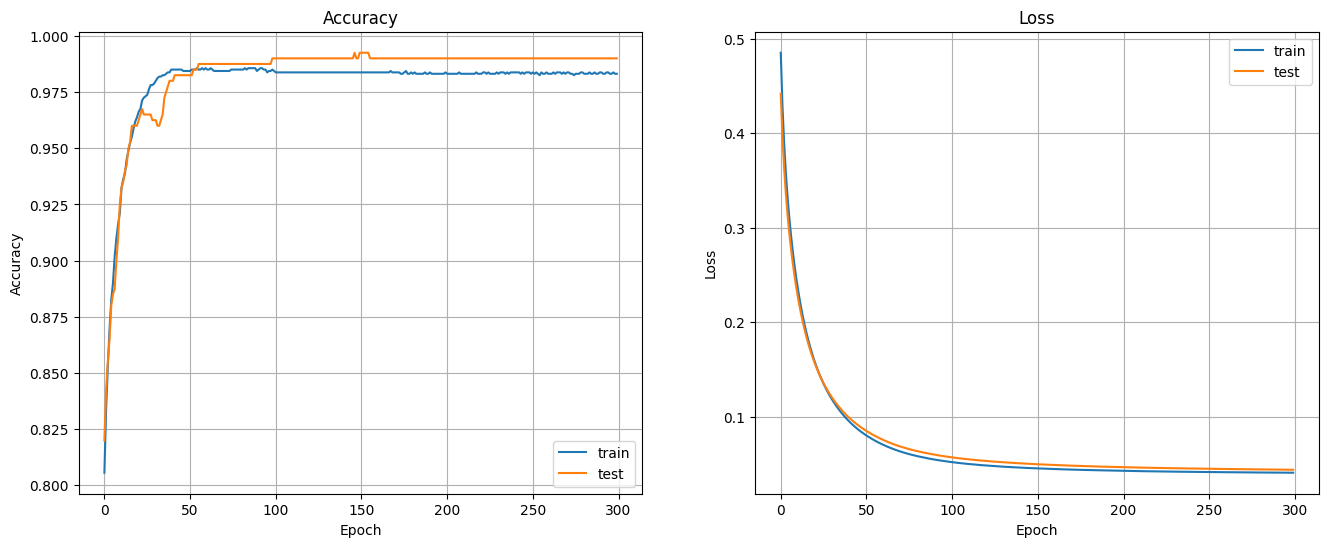

In [22]:
net = SimpleNet(2, 1)
criterion = nn.BCELoss()
optimizer = CustomAdamOptimizer(net.parameters())

hist_loss, hist_acc, hist_test_loss, hist_acc_test = train(net, trainloader, testloader, criterion, optimizer, num_epochs=300, verbose=False, full_grad=True)


## plot 2 figures for accuracy and loss side by side
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(hist_acc, label='train')
plt.plot(hist_acc_test, label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist_loss, label='train')
plt.plot(hist_test_loss, label='test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# Task4: Investigating Optimization accuracy and complexity
* compare and plot the learning curves (testing-training loss vs. time) for all three optimizers to observe the differences.
* Show how the distribution of weights change over different layers, by a histogram


In [78]:
import copy

# net1 = SimpleNet(2, 1)
# net2 = SimpleNet(2, 1)
# net3 = SimpleNet(2, 1)
# net4 = SimpleNet(2, 1)

hid_dim = 5
net1 = MLP(2, hid_dim,  1)
net2 = MLP(2, hid_dim, 1)
net3 = MLP(2, hid_dim, 1)
net4 = MLP(2, hid_dim, 1)



nets = {
    'Adagrad': net1,
    'Adadelta': net2,
    'Adam': net3,
    'CustomAdam': net4
}

optimizer1 = AdagradOptimizer(net1.parameters(), lr=lr)
optimizer2 = AdadeltaOptimizer(net2.parameters(), rho=0.8, eps=1e-6)
optimizer3 = Adam(net3.parameters(), lr=.001, beta1=.9, beta2=.999, eps=1e-8)
optimizer4 = CustomAdamOptimizer(net4.parameters())

optimizers = {
    'Adagrad': optimizer1,
    'Adadelta': optimizer2,
    'Adam': optimizer3,
    'CustomAdam': optimizer4
}

criterion = nn.BCELoss()

history = {}
models = {}
f_grad = False
for i, key in enumerate(nets):

        if i == 3:
            f_grad = True

        hist_loss, hist_acc, hist_test_loss, hist_acc_test = train(nets[key], trainloader, testloader, criterion, optimizers[key], num_epochs=70, verbose=False, full_grad=f_grad)

        history[key] = [hist_loss, hist_acc, hist_test_loss, hist_acc_test]
        models[key] = copy.deepcopy(nets[key])


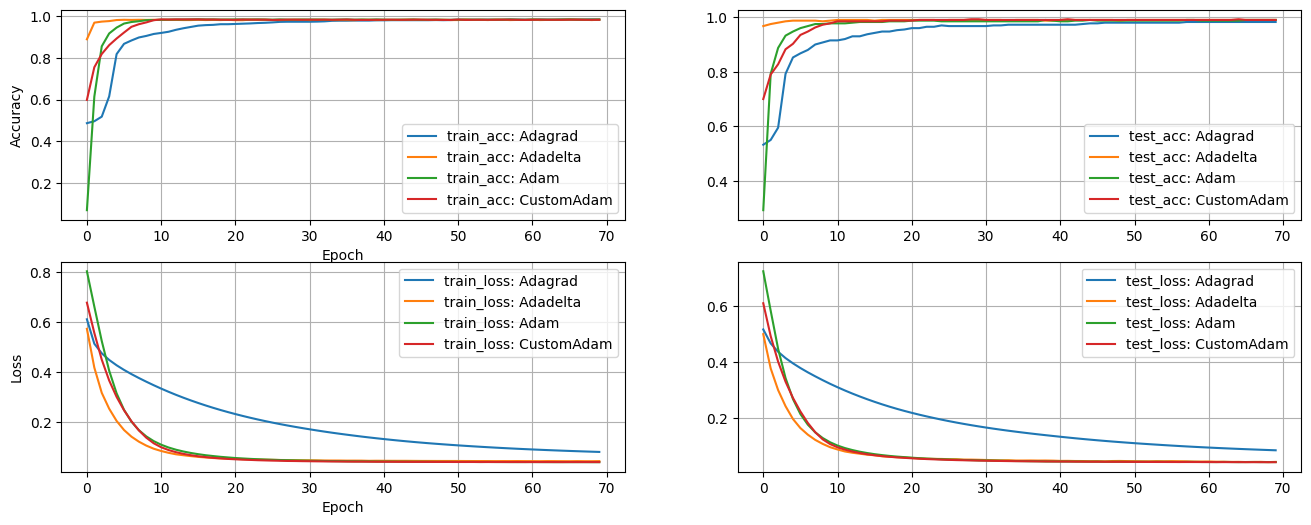

In [79]:

## plot 2 figures for accuracy and loss side by side
plt.figure(figsize=(16, 6))
for i, tup in enumerate(history.items()):
    key, item = tup
    hist_loss, hist_acc, hist_test_loss, hist_acc_test = item
    plt.subplot(2, 2, 1)
    plt.plot(hist_acc, label='train_acc: ' + str(key))
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(hist_acc_test, label='test_acc: ' + str(key))
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(hist_loss, label='train_loss: ' + str(key))
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 4)
    plt.plot(hist_test_loss, label='test_loss: ' + str(key))
    plt.grid(True)
    plt.legend()
plt.show()


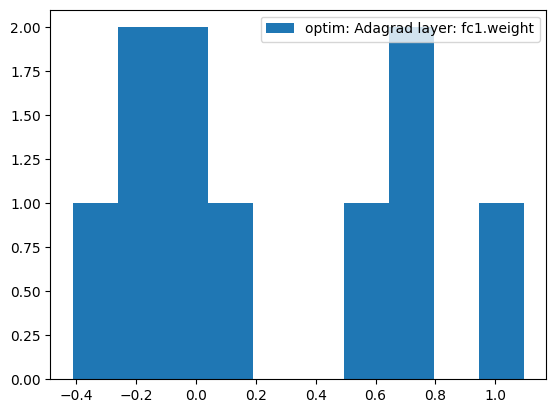

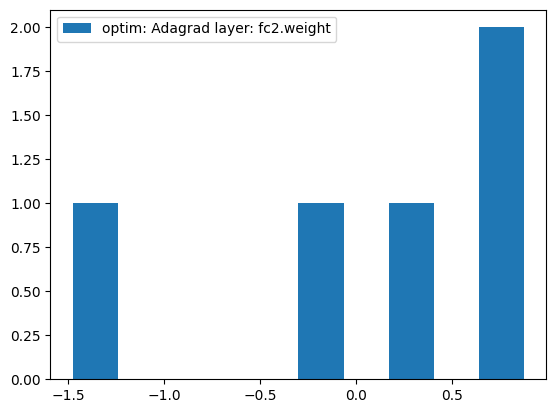

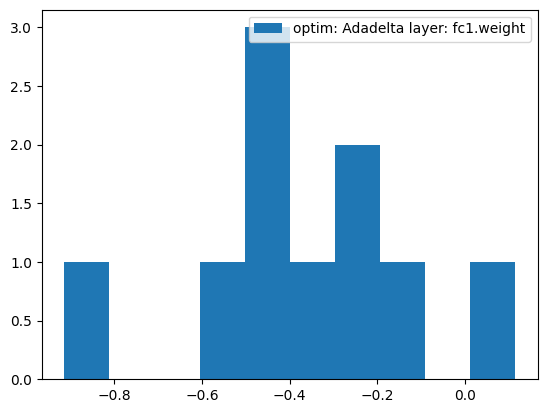

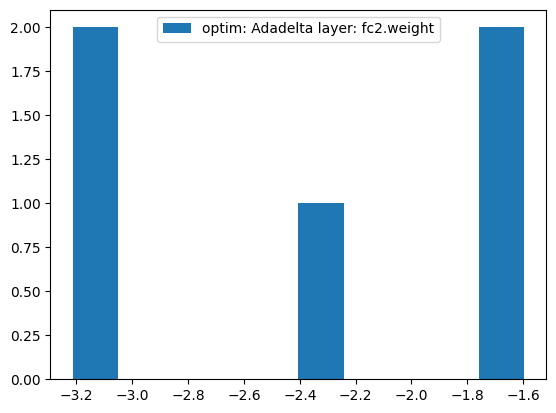

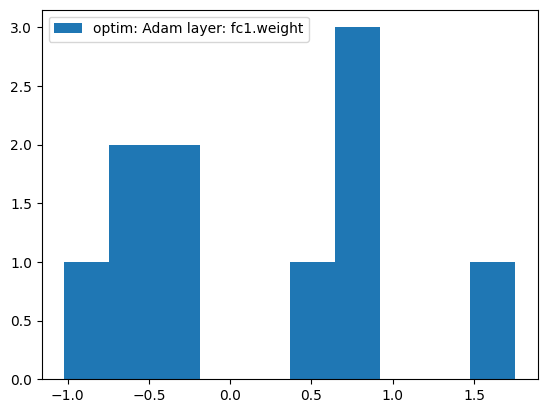

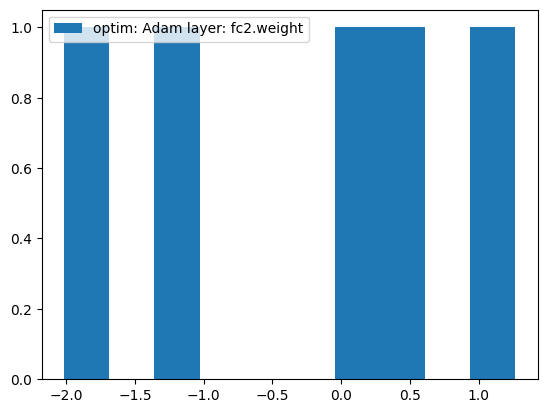

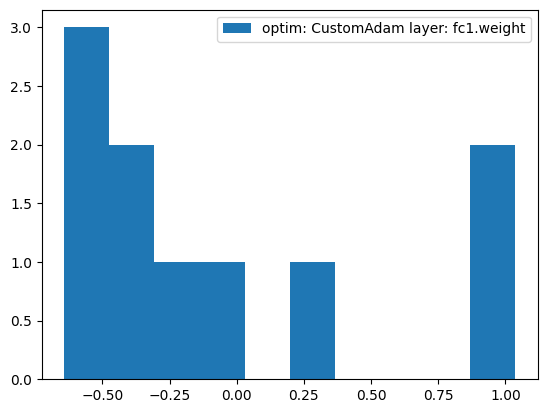

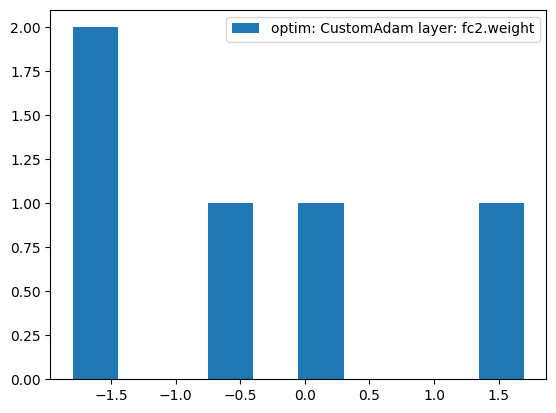

In [80]:
# Show how the distribution of weights change over different layers, by a histogram for each model
# Your code goes here
for i, tup in enumerate(models.items()):
    key, model = tup
    for name, param in model.named_parameters():
        ## for each layer similar layer of eahc model plot the distribution of weights
        if 'weight' in name:
            plt.hist(param.data.numpy().flatten(), bins=10, label= "optim: " + key + ' layer: ' + name)
            plt.legend()
            plt.show()
